In [1]:
!pip install transformers==4.17.0

In [2]:
!pip install spacy

In [3]:
!python -m spacy download en_core_web_sm


     |████████████████████████████████| 13.9 MB 4.4 MB/s            
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
from transformers import BertTokenizer, BertForSequenceClassification
import random
import pandas as pd
pd.set_option('max_colwidth', 0)

model_path =  "./model"
do_lower_case = False
model = BertForSequenceClassification.from_pretrained(model_path, output_attentions=False)
tokenizer = BertTokenizer.from_pretrained(model_path, do_lower_case=do_lower_case)



In [5]:
def load_train_df(train_file):

    df = pd.read_csv(train_file, delimiter="\t", quotechar=None, quoting=3)

    df = df.drop(columns = ["sentence1_binary_parse","sentence2_binary_parse", "sentence1_parse", "sentence2_parse"])
    return df

In [6]:
def load_df(raw_file, pred_file):

    df = pd.read_csv(raw_file, quotechar='"')
    df["prediction"] = pd.read_csv(pred_file, delimiter="\t")["prediction"]

    df = df.drop(columns = ["sentence1_binary_parse","sentence2_binary_parse", "sentence1_parse", "sentence2_parse"])
    return df

df = load_df("./data/dev_matched.csv" , "./data/dev_matched_bert_base_finetune_predict.txt")
df_train = load_train_df("./data/train.tsv")

In [7]:
df.head(n=3)

,index,promptID,pairID,genre,sentence1,sentence2,label1,label2,label3,label4,label5,label,prediction
0,0,63735,63735n,slate,The new rights are nice enough,Everyone really likes the newest benefits,neutral,entailment,neutral,neutral,neutral,001_neutral,001_neutral
1,1,91383,91383c,government,This site includes a list of all award winners and a searchable database of Government Executive articles.,The Government Executive articles housed on the website are not able to be searched.,contradiction,contradiction,contradiction,contradiction,contradiction,002_contradiction,002_contradiction
2,2,755,755e,telephone,uh i don't know i i have mixed emotions about him uh sometimes i like him but at the same times i love to see somebody beat him,"I like him for the most part, but would still enjoy seeing someone beat him.",entailment,entailment,entailment,entailment,entailment,000_entailment,000_entailment


In [8]:
classes = ["000_entailment","001_neutral","002_contradiction"]

In [9]:
original_sentence_a = "little  out that got would we're before space  to well we that would of wish here they i it's that end landfill so be have really the be this help and going do decade a going run to"
#sentence_b= "We have plenty of space in the landfill."
sentence_b= "We have landfill sajk. asa sas asas."

#label = "contradiction"
label = "contradiction"


In [529]:
import numpy as np
import torch

def _chunk(data, chunk_size):
    for i in range(0, len(data), chunk_size):
        yield data[i:i+chunk_size]

def sentence_shuffle(sentence_a, n_gram=1):
    grams =[ " ".join(c) for c in _chunk(sentence_a.split(" "), n_gram )]
    sentence_a = random.sample(grams, len(grams))   
    sentence_a = " ".join(sentence_a)
    
    return sentence_a, None

def drop_word(sentence_a, max_words_to_drop_percent=50, n_gram=1):
    grams =[ " ".join(c) for c in _chunk(sentence_a.split(" "), n_gram )]
    drop_len = int( len(grams) * max_words_to_drop_percent/100) +1
    dropped_words = []
    for i in range(0, drop_len):
        i_drop = random.randint(0, len(grams)-1)
        dropped_words.append(grams[i_drop])
        grams.pop(i_drop)


    sent = " ".join(grams)
    
    
    return sent, dropped_words

def _transformed_score(sentences, sentences_b, labels, labels_order, transform_func, negative_label="001_neutral"):
    
    result = []
    
    negative_result = []
    
    device ="cuda"
    
    model.to(device)
    
    for original_sentence_a, sentence_b, label in zip(sentences, sentences_b, labels):
        original_label_count = 0 
        negative_label_count = 0 


        gt_label_index = labels_order.index(label)
        negative_label_index = labels_order.index(negative_label)
        
        num_shuffles = 50
        
        shuffled_sentences = [transform_func(original_sentence_a)[0]  for _ in range(num_shuffles)]
        
        for batch in _chunk( shuffled_sentences, 8 ):
            
            batch_len=len(batch)

            batch_a, batch_b = batch, [sentence_b] * batch_len
            
            gt_label_indices =  torch.tensor( [gt_label_index] * batch_len )
            
            negative_label_indices = torch.tensor( [negative_label_index] * batch_len )
            
            inputs = tokenizer(batch_a, batch_b, return_tensors='pt',  padding=True, truncation=True, max_length=512)

            for k, v in inputs.items():
                inputs[k] = v.to(device)
                

            classification_logits = model(**inputs)[0]

            results = torch.softmax(classification_logits, dim=1)
          
            pred_indices = torch.argmax(results, dim=1)
            
                        
            original_label_count += (gt_label_indices == pred_indices.cpu()).float().sum()
            negative_label_count += (negative_label_indices == pred_indices.cpu()).float().sum()
                        
        
        result.append(100*original_label_count.item()/num_shuffles)
        negative_result.append(100*negative_label_count.item()/num_shuffles)
        
    return result, negative_result


def _shuffle_score(sentences, sentences_b, labels, labels_order, ngram):
    
    return _transformed_score(sentences, sentences_b, labels, labels_order, transform_func=lambda x: sentence_shuffle(x, ngram), )
    
    
    return result


def _drop_score(sentences, sentences_b, labels, labels_order, word_drop_rate):
    
    return _transformed_score(sentences, sentences_b, labels, labels_order, transform_func=lambda x: drop_word(x, word_drop_rate), )






In [110]:
def simpl(s1, s2):
    model.to("cpu")
        
    inputs = tokenizer(s1, s2, return_tensors='pt',  padding=True, truncation=True, max_length=512)

    classification_logits = model(**inputs)[0]

    results = torch.softmax(classification_logits, dim=1)

    pred_indices = torch.argmax(results, dim=1)
    return  pred_indices[0].item()

In [560]:
from sklearn.feature_extraction.text import TfidfVectorizer
import math

def top_n_grams(sent_list, n_gram, min_df_percent=1):

    min_df = int(len(sent_list) * min_df_percent/100)+1
    c_vec = TfidfVectorizer(lowercase=True,
                    preprocessor=None,
                    tokenizer=None,
                    stop_words='english',
                          ngram_range=(n_gram,n_gram),
                            min_df=32,
                            use_idf=True,
                           ) 
    
    c_vec.fit(sent_list)

    # needs to happen after fit_transform()
    idocumentfreq = c_vec.idf_
    features = c_vec.vocabulary_

    count_values = [ (f,idocumentfreq[i]) for f,i in features.items() ]
    
    doc_len = len(sent_list)
    # output n-grams
    return [ (doc_len * 1/math.exp(ng_count)  , ng_text )for ng_text,ng_count in sorted(count_values, key=lambda x: x[1])]
         

In [561]:
common_words_document_count = top_n_grams(df_train["sentence1"].tolist(), 1)


[(1036.6816253526608, 'school'),
 (1033.3707188132091, 'point'),
 (1031.1634477869088, 'business'),
 (1028.220419751841, 'white'),
 (1027.8525412474578, 'law'),
 (1022.3343636817048, 'came'),
 (1020.1270926554045, '000'),
 (1017.9198216291031, 'set'),
 (1017.9198216291031, 'doing'),
 (1004.6761954712982, 'let'),
 (1001.3652889318465, 'including'),
 (999.1580179055451, 'war'),
 (993.6398403397935, 'office'),
 (990.3289338003422, 'built'),
 (979.2925786688371, 'act'),
 (975.9816721293861, 'fact'),
 (967.152588024182, 'control'),
 (960.5307749452793, 'south'),
 (939.5617001954213, 'provide'),
 (935.1471581428186, 'data'),
 (932.9398871165183, 'children'),
 (928.5253450639163, 'north'),
 (920.7998964718636, 'american'),
 (919.6962609587126, 'hard'),
 (919.6962609587126, 'major'),
 (918.592625445562, 'street'),
 (918.592625445562, 'large'),
 (910.8671768535095, 'gao'),
 (907.5562703140579, 'took'),
 (902.0380927483051, 'family'),
 (895.7841581737863, 'agencies'),
 (894.3126441562522, 'secon

In [465]:
"edinburgh" in common_words

True

In [605]:

from sklearn.feature_extraction import _stop_words
 

def drop_words_in_set(grams_to_drop, sentence_a, max_words_to_drop_percent=50, n_gram=1):
    grams =[ " ".join(c) for c in _chunk(sentence_a.split(" "), n_gram )]
    num_drop = int( len(grams) * max_words_to_drop_percent/100) +1
    dropped_words = []
    drop_len = min(len(grams_to_drop), num_drop)
    drop_positions = [ i for i, g in enumerate(grams) if g.lower() in grams_to_drop]
    dropped_positions = []
    print(drop_len, len(grams_to_drop) , grams_to_drop)
    for i in range(0, drop_len):
        i_drop = random.randint(0, len(drop_positions)-1)
        dropped_words.append(grams[drop_positions[i_drop]])
        dropped_positions.append(drop_positions[i_drop])
        drop_positions.pop(i_drop)

    dropped_positions = set(dropped_positions)
    sent = " ".join([ g for i, g in enumerate(grams) if i not in dropped_positions])
    
    
    return sent, dropped_words

def drop_common_words(sentence_a, max_words_to_drop_percent=50, n_gram=1, common_grams=common_words):
    grams =[ " ".join(c) for c in _chunk(sentence_a.split(" "), n_gram )]
    grams_to_drop = set(common_grams).intersection([ g.lower() for g in grams]) 
    
    return drop_words_in_set(grams_to_drop, sentence_a, max_words_to_drop_percent, n_gram)

def drop_uncommon_words(sentence_a, max_words_to_drop_percent=50, n_gram=1, common_grams=common_words):
    grams =[ " ".join(c) for c in _chunk(sentence_a.split(" "), n_gram )]
    grams_to_drop = set([ g.lower() for g in grams]) - set(common_grams).union(_stop_words.ENGLISH_STOP_WORDS)
    
    
    
    return drop_words_in_set(grams_to_drop, sentence_a, max_words_to_drop_percent, n_gram)

def drop_intersect_words(sentence_a,sentence_b, max_words_to_drop_percent=50, n_gram=1):
    a_grams =[ " ".join(c) for c in _chunk(sentence_a.split(" "), n_gram )]
    b_grams =[ " ".join(c) for c in _chunk(sentence_b.split(" "), n_gram )]
    grams_to_drop = set([ g.lower() for g in a_grams]).intersection(set([ g.lower() for g in b_grams]))
    
    
    
    return drop_words_in_set(grams_to_drop, sentence_a, max_words_to_drop_percent, n_gram)



common_words = {i[1] for i in common_words_document_count}

total_match = 0
num_runs = 4
for i in range(num_runs):
    print("---")
    main_s = "Managing better requires that agencies have, and rely upon, sound financial and program information."
    s2 = "To manage better, agencies often need to rely on unsound information."

    s , dropped  = drop_intersect_words(main_s, s2, 0, 1) #  #drop_common_words(main_s, 1, 1)#
    print(dropped)
    original_pred = "002_contradiction"

    sb = s2

  
    pred_index = simpl(s, sb)
    if classes[pred_index] ==  original_pred:
        total_match += 1
    

    print(s, ":", sb, ":", classes[pred_index] )
print(total_match/num_runs)

---
1 3 {'agencies', 'information.', 'rely'}
['agencies']
Managing better requires that have, and rely upon, sound financial and program information. : To manage better, agencies often need to rely on unsound information. : 001_neutral
---
1 3 {'agencies', 'information.', 'rely'}
['rely']
Managing better requires that agencies have, and upon, sound financial and program information. : To manage better, agencies often need to rely on unsound information. : 001_neutral
---
1 3 {'agencies', 'information.', 'rely'}
['rely']
Managing better requires that agencies have, and upon, sound financial and program information. : To manage better, agencies often need to rely on unsound information. : 001_neutral
---
1 3 {'agencies', 'information.', 'rely'}
['information.']
Managing better requires that agencies have, and rely upon, sound financial and program : To manage better, agencies often need to rely on unsound information. : 001_neutral
0.0


In [133]:
df_train[ df_train["sentence1"].str.contains("silent")]["gold_label"].value_counts()

contradiction    72
neutral          72
entailment       72
Name: gold_label, dtype: int64

In [164]:
t = df.query("label != '001_neutral'").sample(n=500)


In [165]:
t["num_words_sentence1"] = df["sentence1"].apply(lambda x: len(x.split(" ")))



In [184]:
%%time

result, result_negative = _shuffle_score(t["sentence1"],t["sentence2"], t["prediction"], classes, ngram=1)
t["shuffle_score"] = result
t["shuffle_negative_score"] = result_negative


KeyboardInterrupt: 

In [167]:
%%time

result, result_negative = _drop_score(t["sentence1"],t["sentence2"], t["prediction"], classes, word_drop_rate=50)
t["worddrop_score"] = result
t["worddrop_negative_score"] = result_negative

CPU times: user 1min 26s, sys: 21 ms, total: 1min 26s
Wall time: 1min 26s


In [168]:
t["worddrop_negative_score"].describe()

count    500.000000
mean     50.804000 
std      35.119972 
min      0.000000  
25%      18.000000 
50%      54.000000 
75%      82.500000 
max      100.000000
Name: worddrop_negative_score, dtype: float64

In [601]:
t.query("worddrop_negative_score  > 80 and prediction == '002_contradiction' ")

,index,promptID,pairID,genre,sentence1,sentence2,label1,label2,label3,label4,...,label,prediction,num_words_sentence1,shuffle_score,shuffle_negtive_score,worddrop_score,worddrop_negative_score,sen1_sen2_sim,shuffle_negative_score,sen1_train_sim
7594,7695,128832,128832c,fiction,At the pictures the crooks always have a restoorant in the Underworld.,The crooks spent the day at the movies.,contradiction,contradiction,neutral,neutral,...,002_contradiction,002_contradiction,12,16.0,84.0,10.0,90.0,0.708010,84.0,0.617072
5482,5532,86472,86472c,slate,Slate could have put someone with a reasonable grasp of elementary finance and a balanced viewpoint in charge of writing a tax piece.,Slate put an expert in charge of writing their tax pieces.,contradiction,contradiction,contradiction,contradiction,...,002_contradiction,002_contradiction,23,0.0,46.0,8.0,86.0,0.459279,46.0,0.547564
7324,7425,71447,71447c,telephone,oh yeah well i play softball a couple of times a year it's they're getting ready to start up the the season again,They play softball all times of the year,contradiction,contradiction,contradiction,contradiction,...,002_contradiction,002_contradiction,23,4.0,92.0,2.0,98.0,0.492366,92.0,0.579628
6219,6284,66858,66858c,government,"Managing better requires that agencies have, and rely upon, sound financial and program information.","To manage better, agencies often need to rely on unsound information.",contradiction,contradiction,contradiction,contradiction,...,002_contradiction,002_contradiction,14,32.0,68.0,0.0,100.0,0.381881,68.0,0.602512
1992,1992,8269,8269c,travel,With a little practice almost anyone can flip off to an interesting rock formation and watch the multi-coloured fish pass in review.,It would take years of practice to be able to jump off a rock.,contradiction,contradiction,contradiction,contradiction,...,002_contradiction,002_contradiction,22,0.0,100.0,0.0,100.0,0.339550,100.0,0.424815
2021,2021,138337,138337e,slate,"Also, why Princess Di was like President The public cared more about her empathy than about her actions.",They scared more about empathy than actions.,entailment,contradiction,entailment,entailment,...,000_entailment,002_contradiction,19,14.0,64.0,6.0,92.0,0.533333,64.0,0.430923
5067,5117,51995,51995c,travel,"Traffic, also, has been controlled, and if you're staying here you might want to consider getting around by bicycle; there's no better way to explore an island that measures no more than 20 km (121.2 miles) from end to end, one-fifth the size of Ibiza.",The traffic is completely uncontrolled and very heavy.,contradiction,contradiction,contradiction,contradiction,...,002_contradiction,002_contradiction,45,72.0,28.0,18.0,82.0,0.151307,28.0,0.544206
999,999,49228,49228c,travel,"When the two nations divided it up, France got 54 sq km (21 sq miles) and Holland agreed to take just 41 sq km (16 sq miles), but that included the important salt pond near the Dutch capital of Philipsburg.",The French ended up with control over the salt pound.,contradiction,contradiction,contradiction,contradiction,...,002_contradiction,002_contradiction,40,8.0,90.0,0.0,100.0,0.296957,90.0,0.537367
4538,4588,81579,81579e,government,All were prominent nationally known organizations.,The only identified organizations were well-known.,entailment,neutral,entailment,contradiction,...,000_entailment,002_contradiction,6,88.0,12.0,18.0,82.0,0.503953,12.0,0.472860


In [170]:
# import spacy
# nlp = spacy.load('en_core_web_sm')
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics.pairwise import cosine_similarity,cosine_distances




def sim(sen1, sen2, tokenisor = tokenizer.tokenize):

    vectorizer = CountVectorizer(lowercase=True,
                    preprocessor=None,
                    tokenizer=tokenisor,
                    stop_words=None ) 
    vectorizer.fit([sen1, sen2])

    v1 = vectorizer.transform([sen1])
    v2 = vectorizer.transform([sen2])
    
    result=cosine_similarity(v1,v2)
    

    
    return result[0][0]


def top_n_sim(sentences1, sentences2, n=5, tokenisor = tokenizer.tokenize):

    vectorizer = CountVectorizer(lowercase=True,
                    preprocessor=None,
                    tokenizer=tokenisor,
                    stop_words=None ) 
    vectorizer.fit(sentences1)

    v1 = vectorizer.transform(sentences1)
    v2 = vectorizer.transform(sentences2)
   

    pairwise_sim =cosine_similarity(v2,v1)
    top_n = np.partition(pairwise_sim, -n, axis=1)[:, -n:]

    result = np.average(top_n, axis=1)

    
    return result




In [171]:
%%time 

t["sen1_sen2_sim"] = t.apply(lambda r: sim(r["sentence1"] , r["sentence2"]) ,axis=1)

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CPU times: user 1.55 s, sys: 0 ns, total: 1.55 s
Wall time: 1.54 s


In [172]:
t["sen1_sen2_sim"].describe()

count    500.000000
mean     0.462260  
std      0.189229  
min      0.000000  
25%      0.320760  
50%      0.462910  
75%      0.595992  
max      0.979130  
Name: sen1_sen2_sim, dtype: float64

<AxesSubplot:ylabel='Frequency'>

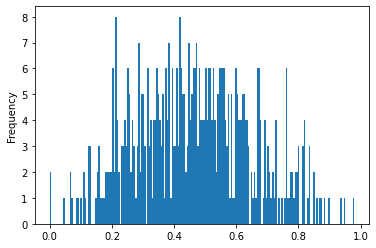

In [173]:
t["sen1_sen2_sim"].plot.hist(bins=200)

<AxesSubplot:ylabel='Frequency'>

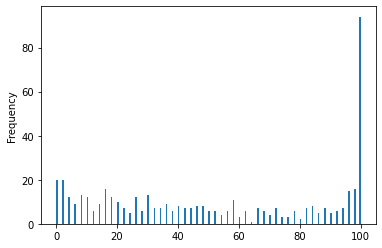

In [174]:
t["worddrop_score"].plot.hist(bins=200)

In [175]:
t["num_words_sentence1"].describe()

count    500.000000
mean     19.432000 
std      14.369493 
min      2.000000  
25%      10.000000 
50%      16.500000 
75%      25.000000 
max      160.000000
Name: num_words_sentence1, dtype: float64

<AxesSubplot:ylabel='Frequency'>

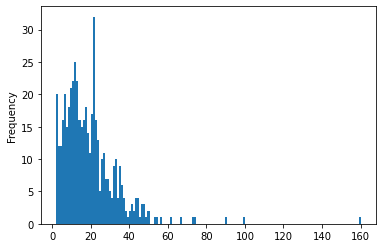

In [176]:
t.query("num_words_sentence1 < 1000")["num_words_sentence1"].plot.hist(bins=150)

<AxesSubplot:xlabel='num_words_sentence1', ylabel='worddrop_score'>

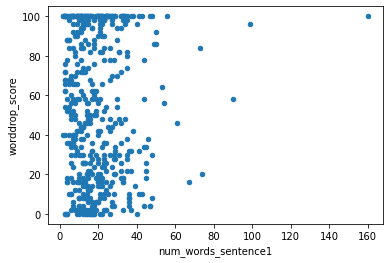

In [177]:
t.query("num_words_sentence1 < 1000") .plot.scatter(y="worddrop_score", x="num_words_sentence1")

In [178]:
t["worddrop_score"].describe()

count    500.000000
mean     53.156000 
std      36.326504 
min      0.000000  
25%      18.000000 
50%      50.000000 
75%      94.500000 
max      100.000000
Name: worddrop_score, dtype: float64

<AxesSubplot:xlabel='sen1_sen2_sim', ylabel='shuffle_score'>

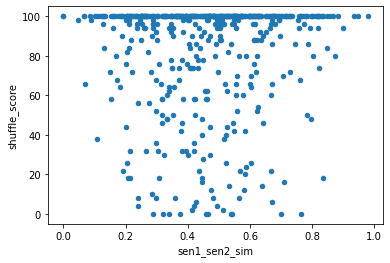

In [179]:
t[["shuffle_score", "sen1_sen2_sim"]].plot.scatter(x="sen1_sen2_sim", y="shuffle_score")

<AxesSubplot:xlabel='sen1_sen2_sim', ylabel='shuffle_negative_score'>

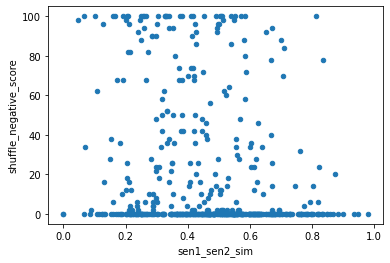

In [186]:
t[["shuffle_negative_score", "sen1_sen2_sim"]].plot.scatter(x="sen1_sen2_sim", y = "shuffle_negative_score")

In [188]:
t["shuffle_negative_score"].describe()

count    500.000000
mean     20.724000 
std      33.951218 
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      28.000000 
max      100.000000
Name: shuffle_negative_score, dtype: float64

<AxesSubplot:ylabel='Frequency'>

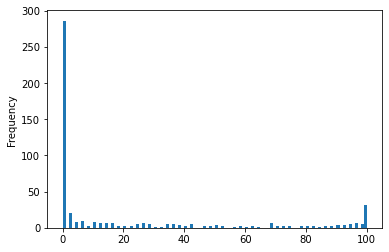

In [187]:
t["shuffle_negative_score"].plot.hist(bins=100)

In [189]:
%%time

t["sen1_train_sim"] = top_n_sim(df_train["sentence1"], t["sentence1"],n=8 )


CPU times: user 5min 45s, sys: 2.19 s, total: 5min 47s
Wall time: 5min 47s


<AxesSubplot:ylabel='Frequency'>

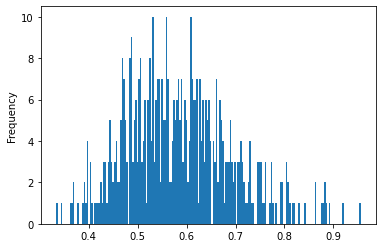

In [190]:
t["sen1_train_sim"].plot.hist(bins=200)

<AxesSubplot:xlabel='sen1_train_sim', ylabel='shuffle_score'>

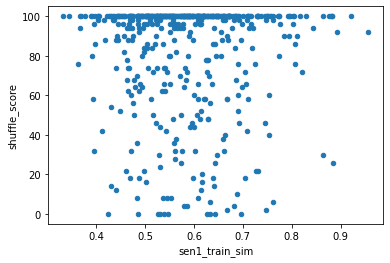

In [191]:
t[["shuffle_score", "sen1_train_sim"]].plot.scatter(x="sen1_train_sim", y="shuffle_score")

<AxesSubplot:xlabel='sen1_train_sim', ylabel='shuffle_negative_score'>

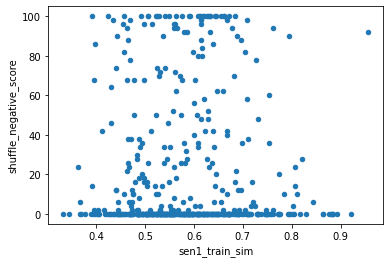

In [201]:
t[["shuffle_negative_score", "sen1_train_sim"]].plot.scatter(x="sen1_train_sim", y="shuffle_negative_score")

In [259]:
(t["label"] == t["prediction"]).sum()/(  len(t))

0.832

In [296]:
t["worddrop_score"].describe()

count    500.000000
mean     53.156000 
std      36.326504 
min      0.000000  
25%      18.000000 
50%      50.000000 
75%      94.500000 
max      100.000000
Name: worddrop_score, dtype: float64

In [299]:
t["shuffle_score"].describe()

count    500.000000
mean     82.408000 
std      28.201848 
min      0.000000  
25%      74.000000 
50%      100.000000
75%      100.000000
max      100.000000
Name: shuffle_score, dtype: float64

In [309]:
threshold =  50
t_high_negative = t.query(f"worddrop_score < {threshold}")
a,b = (t_high_negative["label"] == t_high_negative["prediction"]).sum(), len(t_high_negative)
print(a/(b), len(t_high_negative)/len(t) )


t_high_negative = t.query(f"worddrop_score  >= {threshold}")
a,b = (t_high_negative["label"] == t_high_negative["prediction"]).sum(), len(t_high_negative)
print(a/(b), len(t_high_negative)/len(t) )

0.9116465863453815 0.498
0.7529880478087649 0.502


In [236]:
37 / 47

0.7872340425531915

In [234]:
379 / 453

0.8366445916114791

In [214]:
t_high_negative[t_high_negative["label"] == t_high_negative["prediction"]] 

,index,promptID,pairID,genre,sentence1,sentence2,label1,label2,label3,label4,...,label,prediction,num_words_sentence1,shuffle_score,shuffle_negtive_score,worddrop_score,worddrop_negative_score,sen1_sen2_sim,shuffle_negative_score,sen1_train_sim
1877,1877,887,887c,telephone,more of a football powerhouse up there i guess,He's terrible at football there.,contradiction,contradiction,contradiction,contradiction,...,002_contradiction,002_contradiction,9,100.0,0.0,72.0,28.0,0.223607,0.0,0.612808
8327,8428,10916,10916c,fiction,He'd gone a long way on what he'd found in one elementary book.,He never found anything in any elementary books.,contradiction,contradiction,contradiction,contradiction,...,002_contradiction,002_contradiction,13,100.0,0.0,100.0,0.0,0.408248,0.0,0.608376
5704,5769,10164,10164c,government,"findings, the Administrator has determined that an environmental impact statement need not be prepared.",The Administrator believes a environmental impact statement should be prepared.,contradiction,contradiction,contradiction,contradiction,...,002_contradiction,002_contradiction,14,26.0,0.0,10.0,76.0,0.603023,0.0,0.644124
6594,6659,105962,105962e,government,"14 Managing for Federal Managers' Views Show Need for Ensuring Top Leadership Skills (GAO-01-127, Oct. 20, 2000); Management Using the Results Act and Quality Management to Improve Federal Performance (GAO/T-GGD-99-151, July 29, 1999); and Management Elements of Successful Improvement Initiatives (GAO/T- GGD-00-26, Oct. 15, 1999).","The documentation for Ensuring Top Leadership Skills is GAO-01-127, Oct. 20, 2000.",entailment,entailment,entailment,entailment,...,000_entailment,000_entailment,48,96.0,0.0,8.0,24.0,0.679922,0.0,0.776843
7309,7410,82972,82972e,government,"Other advantages the Postal Service could retain relate to such things as the payment of taxes, the need for a return on investment, the right of eminent domain, and immunity from parking tickets.",The Postal Service has immunity to parking tickets.,entailment,entailment,entailment,entailment,...,000_entailment,000_entailment,33,100.0,0.0,16.0,74.0,0.485662,0.0,0.685151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747,1747,120023,120023e,government,"It describes six applications of case study methods, including the purposes and pitfalls of each, and explains similarities and differences among the six.",There are six applications for case study methods.,entailment,entailment,entailment,entailment,...,000_entailment,000_entailment,23,100.0,0.0,36.0,64.0,0.364405,0.0,0.644402
2679,2729,71832,71832c,slate,Do you think I should be concerned?,Do you think I should be confident?,contradiction,contradiction,contradiction,contradiction,...,002_contradiction,002_contradiction,7,80.0,20.0,36.0,64.0,0.875000,20.0,0.645842
2280,2280,134655,134655e,travel,Catch up on the Indian avant-garde and the bohemian people of Caletta at the Academy of Fine Arts on the southeast corner of the Maidan.,In South-Eastern Maidan you will find the Academy of Fine Arts.,entailment,entailment,entailment,entailment,...,000_entailment,000_entailment,25,66.0,0.0,10.0,72.0,0.520480,0.0,0.706293
7847,7948,60397,60397e,telephone,i don't know what kind of a summer we're expecting this year i imagine it's going to be hot again,I guess this summer will be another warm one; we'll see.,entailment,entailment,entailment,entailment,...,000_entailment,000_entailment,20,76.0,4.0,6.0,88.0,0.398527,4.0,0.724164


<AxesSubplot:ylabel='Frequency'>

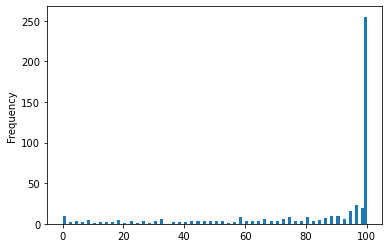

In [192]:
t["shuffle_score"].plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

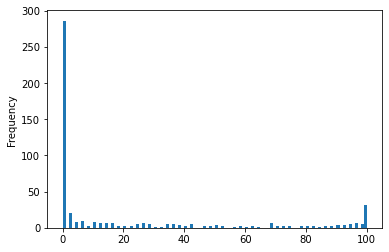

In [200]:
t["shuffle_negative_score"].plot.hist(bins=100)

In [193]:
t["worddrop_score"].describe()

count    500.000000
mean     53.156000 
std      36.326504 
min      0.000000  
25%      18.000000 
50%      50.000000 
75%      94.500000 
max      100.000000
Name: worddrop_score, dtype: float64

In [194]:
t["shuffle_score"].describe()

count    500.000000
mean     82.408000 
std      28.201848 
min      0.000000  
25%      74.000000 
50%      100.000000
75%      100.000000
max      100.000000
Name: shuffle_score, dtype: float64

<AxesSubplot:xlabel='sen1_train_sim', ylabel='shuffle_score'>

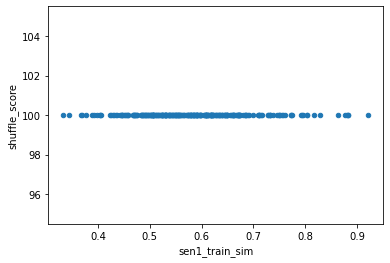

In [195]:
t.query("shuffle_score == 100")[["shuffle_score", "sen1_train_sim"]].plot.scatter(x="sen1_train_sim", y="shuffle_score")

<AxesSubplot:xlabel='worddrop_score', ylabel='shuffle_score'>

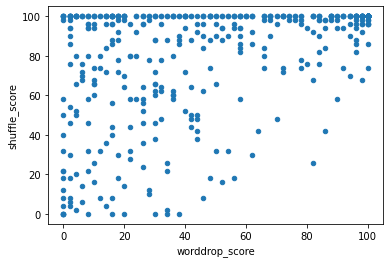

In [196]:
t.plot.scatter(y="shuffle_score", x="worddrop_score")

In [197]:
t.query("shuffle_score <= 50 and worddrop_score <= 50")

,index,promptID,pairID,genre,sentence1,sentence2,label1,label2,label3,label4,...,label,prediction,num_words_sentence1,shuffle_score,shuffle_negtive_score,worddrop_score,worddrop_negative_score,sen1_sen2_sim,shuffle_negative_score,sen1_train_sim
5704,5769,10164,10164c,government,"findings, the Administrator has determined that an environmental impact statement need not be prepared.",The Administrator believes a environmental impact statement should be prepared.,contradiction,contradiction,contradiction,contradiction,...,002_contradiction,002_contradiction,14,26.0,0.0,10.0,76.0,0.603023,0.0,0.644124
9162,9263,54456,54456n,telephone,you don't think it's a deterrent,You have absolutely no doubt whatsoever that it will not be a deterrent,neutral,contradiction,contradiction,contradiction,...,002_contradiction,001_neutral,6,2.0,2.0,34.0,34.0,0.414039,2.0,0.746888
6428,6493,133789,133789e,travel,"Despite their 17th-century origins, these gardens avoid the rigid geometry of the Tuileries and Ver?­sailles.",The gardens are not shaped like the Tuileries or Versailles.,entailment,entailment,entailment,entailment,...,000_entailment,000_entailment,15,4.0,70.0,14.0,74.0,0.420084,70.0,0.681668
6118,6183,83248,83248c,fiction,"Her state is probably to be attributed to the mental shock consequent on recovering her memory.""",It is too bad that she never regained her memory.,contradiction,neutral,neutral,contradiction,...,002_contradiction,001_neutral,16,18.0,18.0,48.0,48.0,0.307729,18.0,0.487826
7594,7695,128832,128832c,fiction,At the pictures the crooks always have a restoorant in the Underworld.,The crooks spent the day at the movies.,contradiction,contradiction,neutral,neutral,...,002_contradiction,002_contradiction,12,16.0,84.0,10.0,90.0,0.708010,84.0,0.617072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5634,5684,124167,124167e,travel,"Among the sights in Beziers are the ancient Eglise Saint Jacques and Eglise Sainte Madeleine, the 19th-century Halles (covered market), and the massive Cathedrale Saint-Nazaire, from which there is a good view over the river valley.","There are many sights to see in Beziers, including the Cathedrale Saint-Nazaire.",entailment,entailment,entailment,entailment,...,000_entailment,000_entailment,36,20.0,80.0,4.0,96.0,0.585242,80.0,0.615988
3540,3590,16030,16030e,travel,His grandson Akbar chose Agra for his capital over Delhi.,"His grandson chose Agra for the capital, not Delhi.",entailment,entailment,entailment,entailment,...,000_entailment,000_entailment,10,0.0,0.0,0.0,68.0,0.763542,0.0,0.485054
3214,3264,10561,10561c,government,"Lalley also is enthused about other bar efforts on behalf of the poor, most notably the Legal Assistance Center will operate out of the new courthouse.",The Legal Assistance Center will keep offering its services from its current location.,contradiction,contradiction,contradiction,contradiction,...,002_contradiction,002_contradiction,26,50.0,50.0,42.0,58.0,0.316228,50.0,0.573674
4703,4753,18427,18427e,telephone,well that's not why i got it right how do you like your tread mill,That is not the reason I got it.,entailment,entailment,entailment,entailment,...,000_entailment,000_entailment,16,32.0,0.0,22.0,26.0,0.392837,0.0,0.562082


In [198]:
t.query("worddrop_score == 100" ).sort_values(by=["worddrop_score"])[:30]

,index,promptID,pairID,genre,sentence1,sentence2,label1,label2,label3,label4,...,label,prediction,num_words_sentence1,shuffle_score,shuffle_negtive_score,worddrop_score,worddrop_negative_score,sen1_sen2_sim,shuffle_negative_score,sen1_train_sim
8327,8428,10916,10916c,fiction,He'd gone a long way on what he'd found in one elementary book.,He never found anything in any elementary books.,contradiction,contradiction,contradiction,contradiction,...,002_contradiction,002_contradiction,13,100.0,0.0,100.0,0.0,0.408248,0.0,0.608376
2338,2338,19884,19884c,government,"The AMS system also allows users to search the full text of the public comments, identifies form letter comments and ex parte communications,8 and provides a list of related government web sites-features that are currently not available in the DOT docket management system.",The AMS system is the most popular hot dog stand outside of the Pentagon.,contradiction,contradiction,contradiction,contradiction,...,002_contradiction,001_neutral,43,100.0,100.0,100.0,100.0,0.450850,100.0,0.590037
6116,6181,113926,113926c,government,Such experience better enables the CIOs to work with business managers to build a shared vision for meeting mission needs.,The managers stormed out of the meeting because they did not share the same vision for the organization anymore.,contradiction,contradiction,neutral,contradiction,...,002_contradiction,002_contradiction,20,100.0,0.0,100.0,0.0,0.324760,0.0,0.484993
2891,2941,9956,9956c,travel,"Under Ferdinand and Isabella, Spain underwent a dramatic transformation.",Spain embarked on a long period of stagnation under Ferdinand and Isabella.,contradiction,contradiction,contradiction,neutral,...,002_contradiction,002_contradiction,9,100.0,0.0,100.0,0.0,0.688033,0.0,0.506049
383,383,113585,113585c,telephone,we only have to get up for you know for the daytime feedings,"We can sleep all day, since we don't have any daytime feedings.",contradiction,contradiction,contradiction,contradiction,...,002_contradiction,002_contradiction,13,100.0,0.0,100.0,0.0,0.344124,0.0,0.513630
9146,9247,76521,76521e,fiction,said San'doro.,San'doro spoke.,entailment,entailment,entailment,entailment,...,000_entailment,000_entailment,3,100.0,0.0,100.0,0.0,0.857143,0.0,0.881917
1672,1672,8994,8994c,fiction,"Sit down, will you?"" Tuppence sat down on the chair facing him.",He told Tuppence to get out.,contradiction,contradiction,neutral,contradiction,...,002_contradiction,002_contradiction,12,100.0,0.0,100.0,0.0,0.345033,0.0,0.524254
6556,6621,86429,86429c,government,Agencies may perform the analyses required by sections 603 and 604 in conjunction with or as part of any other agenda or analysis required by other law if such other analysis satisfies the provisions of these sections.,The agency is free to decide not to perform the analyses covered in section 603.,contradiction,contradiction,contradiction,contradiction,...,002_contradiction,002_contradiction,37,100.0,0.0,100.0,0.0,0.300050,0.0,0.469146
297,297,7362,7362c,telephone,well i think of uh you mean as far as retirement,You never discuss retirement.,contradiction,contradiction,contradiction,contradiction,...,002_contradiction,002_contradiction,11,100.0,0.0,100.0,0.0,0.248069,0.0,0.587955
8357,8458,145627,145627c,travel,Duke William returned from his conquest of England to attend the consecration of Notre-Dame in 1067.,Duke William failed to attend the consecration of Notre-Dame.,contradiction,contradiction,contradiction,contradiction,...,002_contradiction,002_contradiction,16,98.0,0.0,100.0,0.0,0.755929,0.0,0.664455


In [199]:
t.query("shuffle_score > 99" ).sort_values(by=["shuffle_score"])[:30]

,index,promptID,pairID,genre,sentence1,sentence2,label1,label2,label3,label4,...,label,prediction,num_words_sentence1,shuffle_score,shuffle_negtive_score,worddrop_score,worddrop_negative_score,sen1_sen2_sim,shuffle_negative_score,sen1_train_sim
1877,1877,887,887c,telephone,more of a football powerhouse up there i guess,He's terrible at football there.,contradiction,contradiction,contradiction,contradiction,...,002_contradiction,002_contradiction,9,100.0,0.0,72.0,28.0,0.223607,0.0,0.612808
4347,4397,112010,112010n,government,"To provide a useful perspective on how alternative levels of national saving affect future living standards, we also compared our simulation results to a historical benchmark.",Simulations are useful when used in comparison to a historical benchmark.,neutral,entailment,entailment,entailment,...,000_entailment,000_entailment,26,100.0,0.0,48.0,50.0,0.465242,0.0,0.442720
5176,5226,84804,84804c,slate,Ricky Martin was filming his triumphant return to the gay porn industry.,Ricky Martin is heterosexual.,contradiction,contradiction,contradiction,contradiction,...,002_contradiction,002_contradiction,12,100.0,0.0,96.0,4.0,0.484200,0.0,0.369377
8370,8471,125470,125470e,government,"Steps are initiated to allow program board membership to reflect the clienteligible community and include representatives from the funding community, corporations and other partners.",The board includes those from the funding community and corporations.,entailment,entailment,entailment,entailment,...,000_entailment,000_entailment,24,100.0,0.0,26.0,74.0,0.600925,0.0,0.530108
4251,4301,143869,143869c,telephone,and the like a guy does it and he has his own pigs,He doesn't have any pigs so he borrows them.,contradiction,contradiction,contradiction,contradiction,...,002_contradiction,002_contradiction,13,100.0,0.0,58.0,42.0,0.200000,0.0,0.579907
2281,2281,43856,43856c,telephone,did oh they're they are everywhere they,They are only in one area.,contradiction,contradiction,contradiction,contradiction,...,002_contradiction,002_contradiction,7,100.0,0.0,52.0,48.0,0.390360,0.0,0.731281
297,297,7362,7362c,telephone,well i think of uh you mean as far as retirement,You never discuss retirement.,contradiction,contradiction,contradiction,contradiction,...,002_contradiction,002_contradiction,11,100.0,0.0,100.0,0.0,0.248069,0.0,0.587955
7009,7110,26196,26196c,fiction,"Four or five from the town rode past, routed by their diminished numbers and the fury of the Kal and Thorn.",Kal and Thorn were very relaxed.,contradiction,contradiction,contradiction,contradiction,...,002_contradiction,002_contradiction,21,100.0,0.0,82.0,18.0,0.406181,0.0,0.620664
479,479,95102,95102c,fiction,"Yes, you've done very well, young man.","No, you have not done very well.",contradiction,contradiction,contradiction,contradiction,...,002_contradiction,002_contradiction,7,100.0,0.0,96.0,0.0,0.623610,0.0,0.611163
1003,1003,105253,105253e,fiction,"I jumped, coat tails flapping.",I jumped while wearing a coat.,entailment,entailment,entailment,entailment,...,000_entailment,000_entailment,5,100.0,0.0,40.0,60.0,0.534522,0.0,0.489944
